<a href="https://colab.research.google.com/github/Yashu2699/Deep_learning/blob/main/Semantic_seg/UNet_vs_LinkNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install segmentation-models

In [54]:
import tensorflow as tf
import cv2
import segmentation_models as sm
import glob
import os
import numpy as np
import keras
import matplotlib.pyplot as plt
from keras.utils.np_utils import normalize
from keras.metrics import MeanIoU
from datetime import datetime

sm.set_framework('tf.keras')
sm.framework()

'tf.keras'

In [3]:
height = 128
widhth = 128
n_classes = 4

train_images = []
for path in glob.glob('/content/drive/MyDrive/ColabNotebooks/deep learning /Object_Segmentation/image_datasets/images/'):
  for image_path in glob.glob(os.path.join(path, '*.tif')):
    img = cv2.imread(image_path, 1)
    train_images.append(img)
train_images = np.array(train_images)

train_masks = []
for path in glob.glob('/content/drive/MyDrive/ColabNotebooks/deep learning /Object_Segmentation/image_datasets/masks_final'):
  for mask_path in glob.glob(os.path.join(path, '*.tif')):
    mask = cv2.imread(mask_path, 0)
    train_masks.append(mask)
train_masks = np.array(train_masks)

In [16]:
from sklearn.preprocessing import LabelEncoder
n, h, w = train_masks.shape
labelencoder = LabelEncoder()
train_masks_reshape = train_masks.reshape(-1, 1).ravel()
train_masks_encode = labelencoder.fit_transform(train_masks_reshape)
train_masks_ = train_masks_encode.reshape(n, h, w)

In [19]:
train_masks_input = np.expand_dims(train_masks_, axis=3)

from sklearn.model_selection import train_test_split
X, X_test, y, y_test = train_test_split(train_images, train_masks_, test_size=0.10, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=0)

In [31]:
from tensorflow.keras.utils import to_categorical

y_train_input_ = to_categorical(y_train, num_classes=n_classes)
#y_train_input = y_train_input_.reshape((y_train[0], y_train[1], y_train[2], n_classes))

y_valid_input_ = to_categorical(y_valid, num_classes=n_classes)
#y_valid_input = y_valid_input_.reshape((y_valid[0], y_valid[1], y_valid[2], n_classes))

y_test_input_ = to_categorical(y_test, num_classes=n_classes)
#y_test_input = y_test_input_.reshape((y_test[0], y_test[1], y_test[2], n_classes))

In [39]:
activation = 'softmax'
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss()

total_loss = dice_loss + focal_loss

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [41]:
backbone = 'resnet34'
preprocess_input = sm.get_preprocessing(backbone)

X_train_resnet = preprocess_input(X_train)
X_valid_resnet = preprocess_input(X_valid)
X_test_resnet = preprocess_input(X_test)

In [52]:
model_unet = sm.Unet(backbone, encoder_weights='imagenet', activation=activation, classes=n_classes)

model_unet.compile(optimizer, total_loss, metrics=metrics)

In [55]:
start = datetime.now()
history_unet = model_unet.fit(X_train_resnet, y_train_input_,
                              epochs=50, batch_size=16,
                              verbose=1,
                              validation_data=(X_valid_resnet, y_valid_input_))
end = datetime.now()
print('unet training time {}'.format(end-start))

Epoch 1/50
72/72 [==============================] - 46s 357ms/step - loss: 0.7655 - iou_score: 0.1940 - f1-score: 0.2780 - val_loss: 0.8474 - val_iou_score: 0.1237 - val_f1-score: 0.1882
Epoch 2/50
72/72 [==============================] - 23s 325ms/step - loss: 0.5858 - iou_score: 0.4728 - f1-score: 0.5670 - val_loss: 0.6879 - val_iou_score: 0.2891 - val_f1-score: 0.3698
Epoch 3/50
72/72 [==============================] - 24s 334ms/step - loss: 0.4607 - iou_score: 0.6450 - f1-score: 0.7452 - val_loss: 0.6249 - val_iou_score: 0.3907 - val_f1-score: 0.5035
Epoch 4/50
72/72 [==============================] - 23s 324ms/step - loss: 0.3457 - iou_score: 0.7411 - f1-score: 0.8397 - val_loss: 0.4477 - val_iou_score: 0.6261 - val_f1-score: 0.7502
Epoch 5/50
72/72 [==============================] - 24s 336ms/step - loss: 0.2698 - iou_score: 0.7791 - f1-score: 0.8677 - val_loss: 0.3092 - val_iou_score: 0.7661 - val_f1-score: 0.8555
Epoch 6/50
72/72 [==============================] - 24s 336ms/ste

In [56]:
model_unet.save('/content/drive/MyDrive/ColabNotebooks/deep learning /Object_Segmentation/unet_linknet_compare_unet.hdf5')

In [58]:
model_linknet = sm.Linknet(backbone, encoder_weights='imagenet', activation=activation, classes=n_classes)

model_linknet.compile(optimizer, total_loss, metrics=metrics)

In [59]:
start = datetime.now()
history_linknet = model_linknet.fit(X_train_resnet, y_train_input_,
                                    epochs=50, batch_size=16,
                                    verbose=1,
                                    validation_data=(X_valid_resnet, y_valid_input_))
end = datetime.now()
print('linknet training time {}'.format(end-start))

Epoch 1/50
72/72 [==============================] - 29s 303ms/step - loss: 0.5768 - iou_score: 0.4011 - f1-score: 0.4654 - val_loss: 0.7735 - val_iou_score: 0.2578 - val_f1-score: 0.3186
Epoch 2/50
72/72 [==============================] - 22s 304ms/step - loss: 0.2627 - iou_score: 0.7264 - f1-score: 0.8197 - val_loss: 0.6577 - val_iou_score: 0.3703 - val_f1-score: 0.4712
Epoch 3/50
72/72 [==============================] - 22s 309ms/step - loss: 0.1609 - iou_score: 0.8068 - f1-score: 0.8852 - val_loss: 0.3836 - val_iou_score: 0.6159 - val_f1-score: 0.7278
Epoch 4/50
72/72 [==============================] - 21s 292ms/step - loss: 0.1332 - iou_score: 0.8271 - f1-score: 0.8995 - val_loss: 0.1978 - val_iou_score: 0.7759 - val_f1-score: 0.8653
Epoch 5/50
72/72 [==============================] - 22s 305ms/step - loss: 0.1180 - iou_score: 0.8402 - f1-score: 0.9083 - val_loss: 0.1695 - val_iou_score: 0.7858 - val_f1-score: 0.8721
Epoch 6/50
72/72 [==============================] - 21s 294ms/ste

In [ ]:
model_linknet.save('/content/drive/MyDrive/ColabNotebooks/deep learning /Object_Segmentation/unet_linknet_compare_linknet.hdf5')

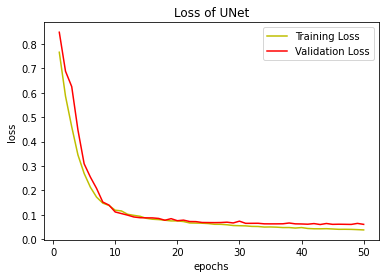

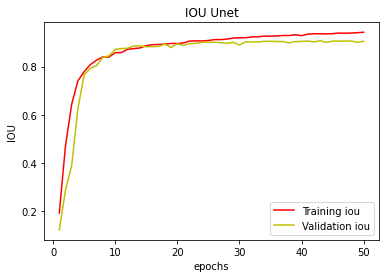

In [63]:
loss = history_unet.history['loss']
val_loss = history_unet.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'y', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss of UNet')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

iou = history_unet.history['iou_score']
val_iou = history_unet.history['val_iou_score']
plt.plot(epochs, iou, 'r', label='Training iou')
plt.plot(epochs, val_iou, 'y', label='Validation iou')
plt.title('IOU Unet')
plt.xlabel('epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

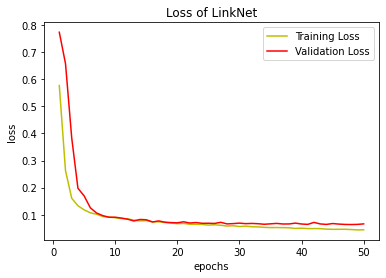

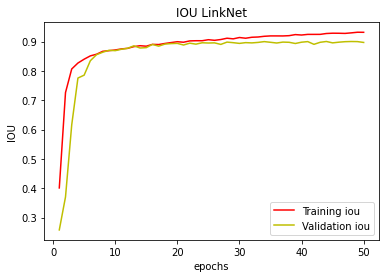

In [64]:
loss = history_linknet.history['loss']
val_loss = history_linknet.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'y', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss of LinkNet')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

iou = history_linknet.history['iou_score']
val_iou = history_linknet.history['val_iou_score']
plt.plot(epochs, iou, 'r', label='Training iou')
plt.plot(epochs, val_iou, 'y', label='Validation iou')
plt.title('IOU LinkNet')
plt.xlabel('epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [70]:
y_pred_unet = model_unet.predict(X_test_resnet)
y_pred_unet_arg = np.argmax(y_pred_unet, axis=3)

y_pred_linknet = model_linknet.predict(X_test_resnet)
y_pred_linknet_arg = np.argmax(y_pred_linknet, axis=3)

IOU_unet = MeanIoU(num_classes=n_classes)  
IOU_unet.update_state(y_test, y_pred_unet_arg)

IOU_linknet = MeanIoU(num_classes=n_classes)  
IOU_linknet.update_state(y_test, y_pred_linknet_arg)

print("Mean IoU using Unet =", IOU_unet.result().numpy())
print("Mean IoU using linknet =", IOU_linknet.result().numpy())

Mean IoU using Unet = 0.90812665
Mean IoU using linknet = 0.8992992


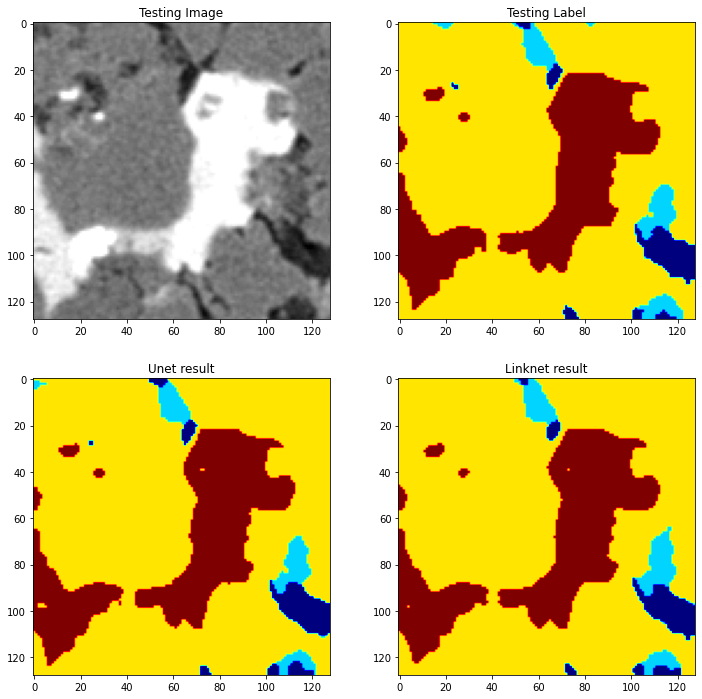

In [74]:
import random
test_img_number = random.randint(0, len(X_test_resnet))
test_img = X_test_resnet[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
test_img_input1 = preprocess_input(test_img_input)

test_pred_unet = model_unet.predict(test_img_input1)
test_prediction_unet = np.argmax(test_pred_unet, axis=3)[0,:,:]

test_pred_linknet = model_linknet.predict(test_img_input1)
test_prediction_linknet = np.argmax(test_pred_linknet, axis=3)[0,:,:]


plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(222)
plt.title('Testing Label')
plt.imshow(ground_truth, cmap='jet')
plt.subplot(223)
plt.title('Unet result')
plt.imshow(test_prediction_unet, cmap='jet')
plt.subplot(224)
plt.title('Linknet result')
plt.imshow(test_prediction_linknet, cmap='jet')
plt.show()
